<a href="https://colab.research.google.com/github/sgparrot/sgparrot2021Lv1-1/blob/main/MNIST/MNIST_%EB%B0%9C%ED%91%9C%EC%9E%90%EB%A3%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Classification

In [1]:
#!/usr/bin/env python3

import os
import math
import argparse

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.data import Dataset
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, Sequence

from copy import deepcopy

### for notebook users
%matplotlib inline

## Preprocessing & Inspecting

### Defining Dataloader
tensorflow.keras.utils.Sequence를 상속받아서 Dataloader라는 class를 생성

In [2]:
class Dataloader(Sequence):

    def __init__(self, x_set, y_set, batch_size, shuffle=False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]

        return np.array(batch_x), np.array(batch_y)
    
    ### Epoch이 한 번 끝날 때마다 shuffle
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

### Generating Datasets

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)


### Preprocessing

In [4]:
target_size = 10

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype("float32") / (2 ** 8 - 1)
X_test = X_test.astype("float32") / (2 ** 8 - 1)

y_train = to_categorical(y_train, target_size)
y_test = to_categorical(y_test, target_size)

In [5]:
train_batch_size = 2 ** 7
test_batch_size = 2 ** 7

train_loader = Dataloader(X_train, y_train, train_batch_size, shuffle=True)
test_loader = Dataloader(X_test, y_test, test_batch_size, shuffle=False)

### Dataset Inspecting

In [6]:
### 임시로 한 개의 minibatch를 돌려보는 상황

examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print("Target: {}".format(example_target.shape))
print("Data  : {}".format(example_data.shape))

Target: (128, 10)
Data  : (128, 28, 28, 1)


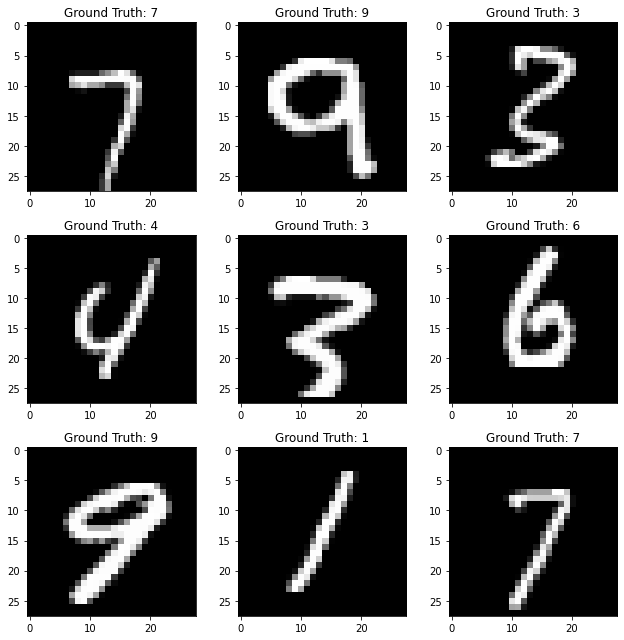

In [7]:
fig = plt.figure(figsize=(9, 9))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(tf.squeeze(example_data[i]), cmap="gray", interpolation="none")
    target = np.where(example_target[i]==1)[0]
    plt.title("Ground Truth: {}".format(int(target)))

plt.show()

## Modeling

In [8]:
def CNN(act, initial, dropout, use_bn):
    
    if act == "ReLU" or act == "relu":
        activation = "relu"
    elif act == "sigmoid":
        activation = "sigmoid"
    elif act == "tanh":
         activation = "tanh"
    elif act == "softmax":
        activation = "softmax"
    else:
        raise ValueError("Not a valid activation function.")
    
    if initial == "Xavier" or initial == "glorot":
        initializer = "glorot_uniform"
    elif initial == "he":
        initializer = "he_uniform"
    else:
        raise ValueError("Not a valid initializer.")
    
    model=Sequential()

    model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), padding="Same",
                            activation=activation, input_shape=(28, 28, 1)))

    if use_bn == True:
        model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), padding="Same",
                            activation=activation))

    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Dropout(dropout))

    if use_bn == True:
        model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding="Same",
                            activation=activation))

    if use_bn == True:
        model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding="Same",
                            activation=activation))

    model.add(layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(layers.Dropout(dropout))

    if use_bn == True:
        model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding="Same",
                            activation=activation))

    model.add(layers.Dropout(dropout))
    model.add(layers.Flatten())

    if use_bn == True:
        model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation=activation))
    model.add(layers.Dropout(dropout))

    if use_bn == True:
        model.add(layers.BatchNormalization())
    model.add(layers.Dense(10, activation="softmax"))
    print(model.summary())
    
    return model

## Experiment

In [9]:
def experiment(args):
    
    model = CNN(act=args.act, initial=args.initializer,
                dropout=args.dropout, use_bn=args.use_bn)
    
    if args.optimizer == "SGD":
        optimizer = tf.keras.optimizers.SGD(learning_rate=args.lr)
    elif args.optimizer == "RMSprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=args.lr)
    elif args.optimizer == "Adam" or args.optimizer == "ADAM":
        optimizer = tf.keras.optimizers.Adam(learning_rate=args.lr)
    else:
        raise ValueError("Not a valid Optimizer.")
    
    model.compile(optimizer=optimizer, loss="categorical_crossentropy",
                  metrics=["accuracy"])
    
    hist = model.fit(X_train, y_train, batch_size=args.train_batch_size,
                 epochs=args.epoch, validation_split=0.2, verbose=1,
                 callbacks=callback_list)
    
    return hist, model

## Hyperparametrization

In [10]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")

### Model
# args.model_code = "VGG16"    # 실행할 모델 이름 (미구현)
args.in_dim = 1 * 28 * 28      # 파일 크기
# args.hidden_dim = 100        # MLP의 Hidden Dimension (미구현)
args.out_dim = 10              # 0부터 9까지, 총 10가지
args.act = "ReLU"              # Activation Function(ReLU, sigmoid, tanh, softmax 구현)
#args.kernel_size = 3          # filter의 size

### Regulization
args.l2 = 5e-5                 # l2 정규화 alpha 값
args.use_bn = True             # Batch Normalization 사용 여부
args.dropout = 0.2             # dropout 비율
args.initializer = "Xavier"    # Initializer 설정(Xavier, he 구현)

### Training & Test
args.optimizer = "RMSprop"     # Optimizer 설정(SGD, RMSprop, Adam 구현)
args.lr = 5e-5                 # Learning Rate
args.epoch = 30                # Epoch 횟수
args.train_batch_size = 2**7   # Training Batch Size
args.test_batch_size = 2**7    # Test Batch Size

### Callback Function
args.monitor = "val_accuracy"  # loss, val_loss, accuracy, val_accuracy
args.patience = 3              # callback function의 patience 값 (0 이상의 정수)
args.min_delta = 0             # patience count의 기준치

### Experiment Variable

name_var1 = ""
name_var2 = ""

list_var1 = []
list_var2 = []

### Defining Callback Function

In [11]:
scheduler = lambda epoch: 0.001 - args.lr + 0.02 * (0.5**(1 + epoch))

lr_scheduler = callbacks.LearningRateScheduler(scheduler)

earlystop = callbacks.EarlyStopping(monitor=args.monitor,
                                    min_delta=args.min_delta,
                                    patience=args.patience,verbose=1,
                                    mode="auto", baseline=None,
                                    restore_best_weights=True)

callback_list = [lr_scheduler, earlystop]

## Evaluation

In [12]:
model_list = []
hist_list = []

count = 0

for var1 in list_var1:
    for var2 in list_var2:
        
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        
        print(args)
        
        hist, model = experiment(deepcopy(args))
        
        model_list.append(model)
        hist_list.append(hist)

### Visualization for Train & Validation

In [13]:
def acc_loss_plot(hist):
    
    fit, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(hist.history["loss"], "y", label="train_loss")
    loss_ax.plot(hist.history["val_loss"], "r", label="val_loss")
    loss_ax.set_xlabel("Epoch")
    loss_ax.set_ylabel("Loss")
    loss_ax.legend(loc = "upper left")
    
    acc_ax.plot(hist.history["accuracy"], "b", label="train_acc")
    acc_ax.plot(hist.history["val_accuracy"], "g", label="val_acc")
    acc_ax.set_ylabel("Accuracy")
    acc_ax.legend(loc = "upper right")
    
    plt.show()

In [14]:
count = 0

for var1 in list_var1:
    for var2 in list_var2:
        
        print("-{0}: {1}, {2}: {3}"
              .format(name_var1, var1, name_var2, var2))
        
        print("Train Loss: {0}, \tTrain Accuracy: {1}"
              .format(hist_list[count].history["loss"][-1],
                     hist_list[count].history["accuracy"][-1]))
        print("Validation Loss: {0}, \tValidation Accuracy: {1}"
              .format(hist_list[count].history["val_loss"][-1],
                     hist_list[count].history["val_accuracy"][-1]))
        
        acc_loss_plot(hist_list[count])
        plt.show()
        
        count +=1

## Test

In [15]:
count = 0

for var1 in list_var1:
    for var2 in list_var2:
        
        print("-{0}: {1}, {2}: {3}"
              .format(name_var1, var1, name_var2, var2))
        
        score = model_list[count].evaluate(X_test, y_test, verbose=0)
        print("Test Loss: {}".format(score[0]))
        print("Test Accuracy: {}\n".format(score[1]))
        
        count += 1

## FINAL RESULT

In [16]:
def multi_train(times):

    hist_list = []
    model_list = []

    for i in range(times):

        hist, model = experiment(deepcopy(args))

        hist_list.append(hist)
        model_list.append(model)

    return hist_list, model_list



def multi_train_result(hist_list, model_list, times):

    for i in range(times):

        print("Train #{0}".format(1 + i))
            
        print("Train Loss: {0}, \tTrain Accuracy: {1}"
            .format(hist_list[i].history["loss"][-1],
                    hist_list[i].history["accuracy"][-1]))
        print("Validation Loss: {0}, \tValidation Accuracy: {1}"
            .format(hist_list[i].history["val_loss"][-1],
                    hist_list[i].history["val_accuracy"][-1]))
        
        acc_loss_plot(hist_list[i])



def multi_test(model_list, times):
    
    mean_test_loss = 0
    mean_test_acc = 0

    for i in range(times):

        score = model_list[i].evaluate(X_test, y_test, verbose=0)
        print("Test #{0}".format(1 + i))
        print("Test Loss: {}".format(score[0]))
        print("Test Accuracy: {}".format(score[1]))

        mean_test_loss += score[0]
        mean_test_acc += score[1]
    
    mean_test_loss /= times
    mean_test_acc /= times

    print("\nAfter learning {} times, we finally obtained".format(times))
    print("Expectation of Test Loss: {}".format(mean_test_loss))
    print("Expectation of Test Accuracy: {}".format(mean_test_acc))

    return mean_test_loss, mean_test_acc



def report(times):

    hist_list, model_list = multi_train(times)
    print("===================================================================")
    multi_train_result(hist_list, model_list, times)
    print("===================================================================")
    mean_test_loss, mean_test_acc = multi_test(model_list, times)

    return [hist_list, model_list, mean_test_loss, mean_test_acc, times]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        3

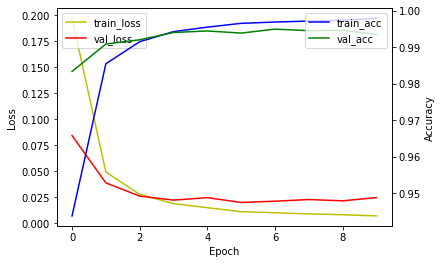

Train #2
Train Loss: 0.005842427723109722, 	Train Accuracy: 0.9980624914169312
Validation Loss: 0.024234868586063385, 	Validation Accuracy: 0.9949166774749756


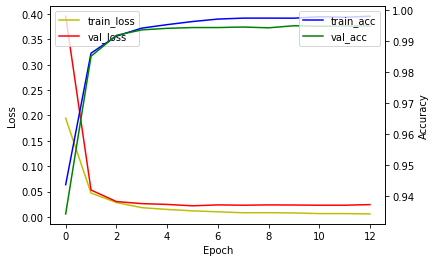

Train #3
Train Loss: 0.007037058938294649, 	Train Accuracy: 0.9977291822433472
Validation Loss: 0.024233488366007805, 	Validation Accuracy: 0.9944999814033508


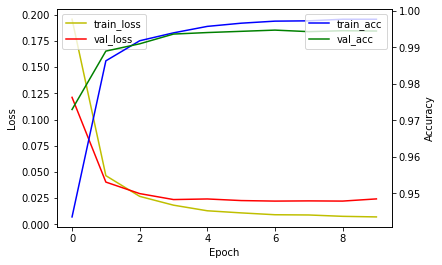

Train #4
Train Loss: 0.0034816411789506674, 	Train Accuracy: 0.9987291693687439
Validation Loss: 0.024583343416452408, 	Validation Accuracy: 0.9949166774749756


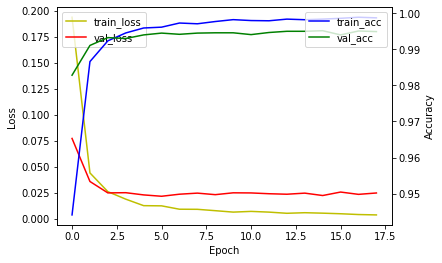

Train #5
Train Loss: 0.00527901342138648, 	Train Accuracy: 0.9982500076293945
Validation Loss: 0.024923939257860184, 	Validation Accuracy: 0.9946666955947876


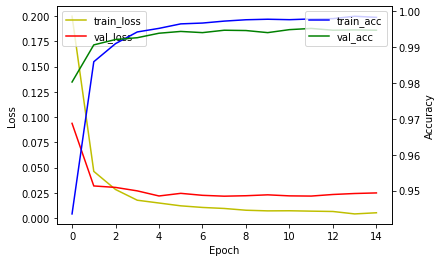

Train #6
Train Loss: 0.005420895759016275, 	Train Accuracy: 0.9982500076293945
Validation Loss: 0.02534315176308155, 	Validation Accuracy: 0.9944166541099548


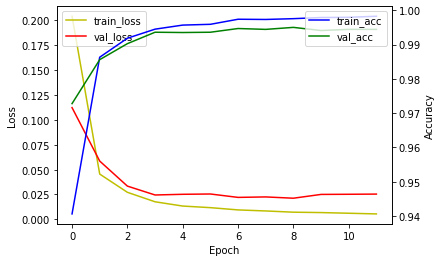

Train #7
Train Loss: 0.006884351838380098, 	Train Accuracy: 0.9977291822433472
Validation Loss: 0.023346571251749992, 	Validation Accuracy: 0.9940833449363708


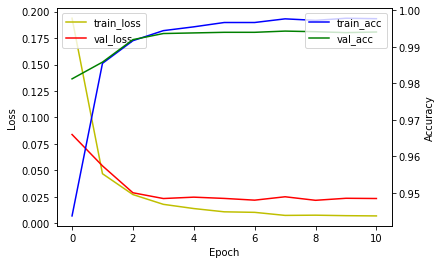

Train #8
Train Loss: 0.0053380331955850124, 	Train Accuracy: 0.9983749985694885
Validation Loss: 0.024499468505382538, 	Validation Accuracy: 0.9941666722297668


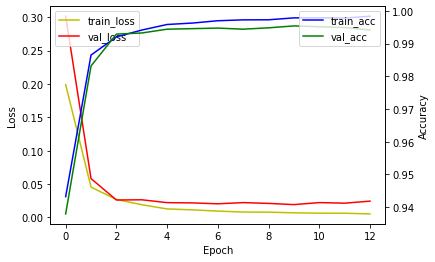

Train #9
Train Loss: 0.008827434852719307, 	Train Accuracy: 0.996916651725769
Validation Loss: 0.022277288138866425, 	Validation Accuracy: 0.9944166541099548


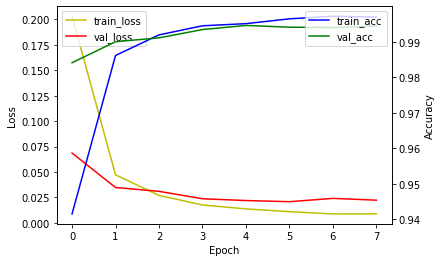

Train #10
Train Loss: 0.00391392782330513, 	Train Accuracy: 0.9986666440963745
Validation Loss: 0.026268839836120605, 	Validation Accuracy: 0.9952499866485596


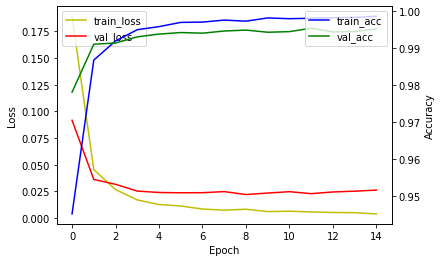

Test #1
Test Loss: 0.014431124553084373
Test Accuracy: 0.9952999949455261
Test #2
Test Loss: 0.014695671387016773
Test Accuracy: 0.9957000017166138
Test #3
Test Loss: 0.01402006484568119
Test Accuracy: 0.9962000250816345
Test #4
Test Loss: 0.01985829323530197
Test Accuracy: 0.995199978351593
Test #5
Test Loss: 0.015552729368209839
Test Accuracy: 0.9955000281333923
Test #6
Test Loss: 0.015672631561756134
Test Accuracy: 0.9962000250816345
Test #7
Test Loss: 0.016758136451244354
Test Accuracy: 0.9952999949455261
Test #8
Test Loss: 0.015691891312599182
Test Accuracy: 0.9957000017166138
Test #9
Test Loss: 0.016842475160956383
Test Accuracy: 0.994700014591217
Test #10
Test Loss: 0.01586771570146084
Test Accuracy: 0.9958000183105469

After learning 10 times, we finally obtained
Expectation of Test Loss: 0.015939073357731103
Expectation of Test Accuracy: 0.9955600082874299


In [17]:
result_list = report(10)

### Review

In [18]:
wrong_result = []

for i in range(result_list[-1]):
    pred_result = result_list[1][i].predict(X_test)
    pred_labels = np.argmax(pred_result, axis = 1)
    test_labels = np.argmax(y_test, axis=1)

    for j in range(0, len(y_test)):
        if pred_labels[j] != test_labels[j]:
            wrong_result.append(j)

wrong_result = np.unique(wrong_result)

num_wrong = len(wrong_result)
sqrt_num_wrong = math.ceil(math.sqrt(num_wrong))

print("{0} data were not matched correctly at least once.".format(num_wrong))

118 data were not matched correctly at least once.


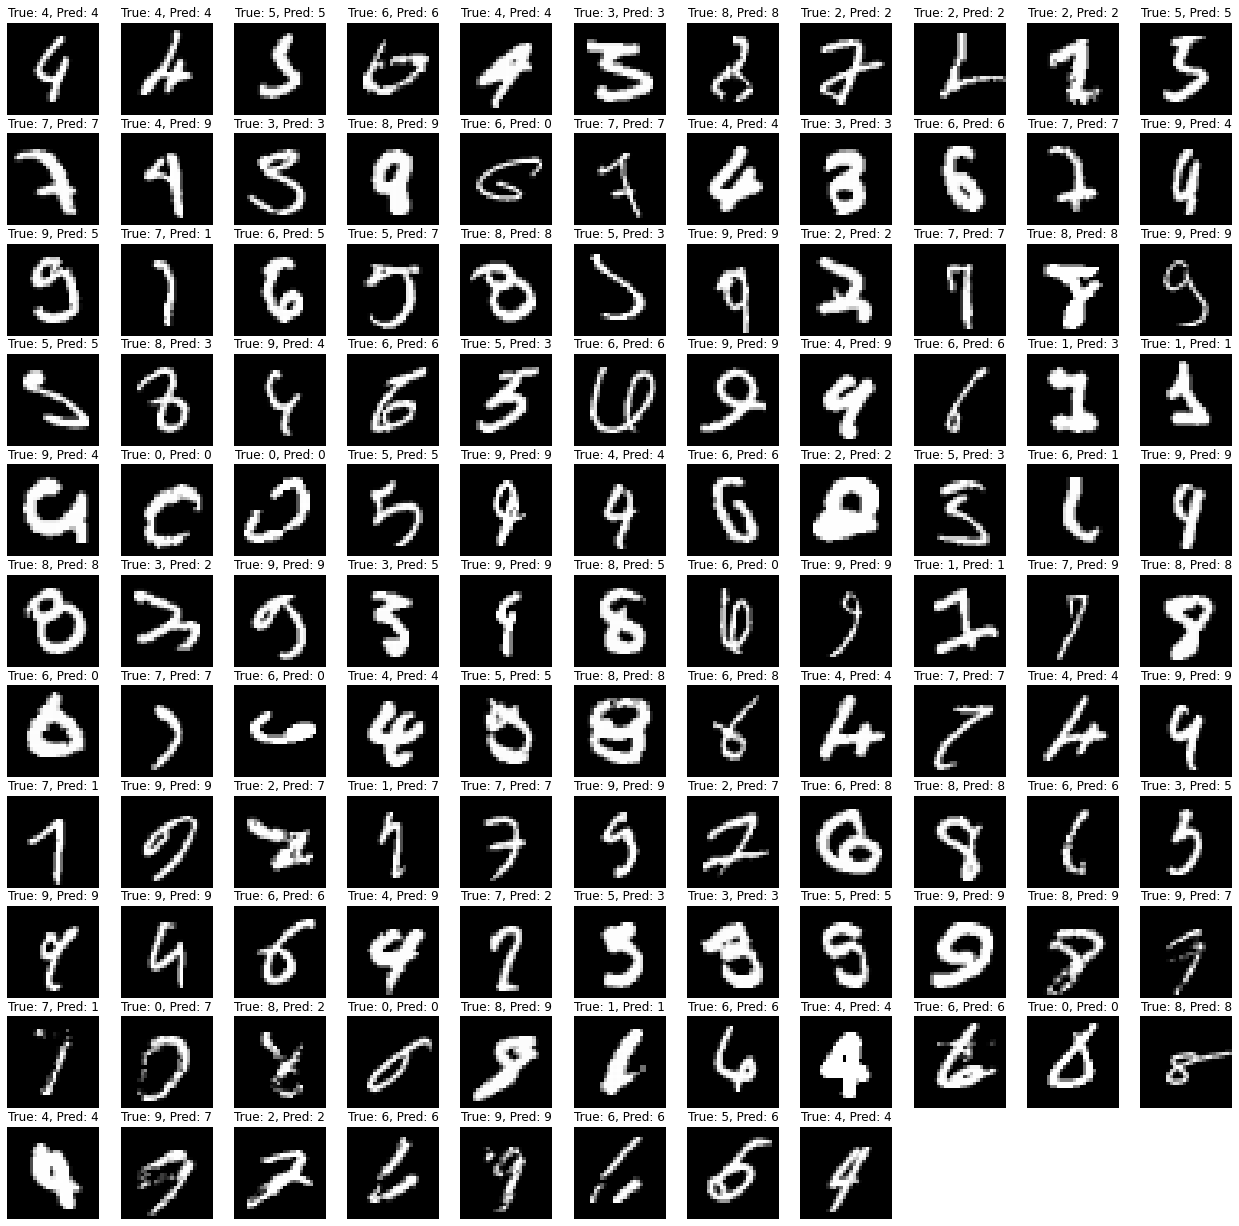

In [19]:
plt.figure(figsize=(2 * sqrt_num_wrong, 2 * sqrt_num_wrong))

for i, j in enumerate(wrong_result):

    plt.subplot(sqrt_num_wrong, sqrt_num_wrong, i + 1)
    plt.imshow(tf.squeeze(X_test[j]), cmap = "gray", interpolation="none")
    plt.title("True: {0}, Pred: {1}".format(test_labels[j], pred_labels[j]))
    plt.axis("off")
    
plt.show()